# Demonstration of soScope working on negative binomial distribution at single cell resolution

This is a demonstration of soScope analysis on simulated data with negative binomial distribution at single cell resolution

Bohan Li @ Deng ai Lab @ BUAA 2024.

Software provided as is under MIT License.

In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    
seed_all(0)


In [2]:
project_name = 'DataSet/sc/'
epochs=[8000, 8000]
device = 'cuda'

## Scene Preset

Experiment: Mouse kidney resolution enhancement experiment.

Inputs: 169 “low-resolution” spots with aggregated gene expressions (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), spatial neighboring relations (A), *and a mask.npy in {0, 1} at 169x1,538 to indicate which cells are assigned to low-resolved spots.*

Outputs: Profiles of 1,538 single cell spots corresponding using Xenium platform.

Genes analyzed: Stmn1, Epcam, Sostdc1, C3, Kcnj16, Lrp2, Plvap, Upk1b, Cubn, Kcnj1.



In [3]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# soScope_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# soScope_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 5 nodes, not to be revised.

two_step_train(logging=not None,
                             vgae_experiment_dir=f'experiments/{project_name}/VGAE_sc',
                             soScope_experiment_dir=f'experiments/{project_name}/soScope_sc_{epochs[0]}_{epochs[1]}',
                             data_dir=project_name,
                             vgae_config_file='config/NB_sc/VGAE.yml',
                             soScope_config_file='config/NB_sc/soScope.yml',
                             device=device,
                             checkpoint_every=1000,
                             backup_every=200,
                             epochs=epochs,
                             num_neighbors=5
                            )


Step 1
<class 'soScope_model.training.vgae.VGAETrainer_NB'>
===There are 169 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 5 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████| 8000/8000 [01:41<00:00, 78.93it/s]


Step 2
<class 'soScope_model.training.sc_model_for_NB.sc_NB'>
Pretrained Model Loaded!
========== Optimization of soScope ============


100%|██████████| 8000/8000 [01:51<00:00, 71.65it/s]


In [4]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 6 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.
infer(
        experiment_dir= f'experiments/{project_name}/soScope_sc_{epochs[0]}_{epochs[1]}',
        non_negative=True,
        num_neighbors=5,
        data_dir= project_name,
        result_dir=project_name,
        device=device,
)

<class 'soScope_model.training.sc_model_for_NB.sc_NB'>
Pretrained Model Loaded!
We built edges between every neighboring 5 nodes
Spatial Data Loaded


In [5]:
# Visualization
# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.
lr_count = np.load(f'{project_name}/label.npy')
position = pd.read_csv(f'{project_name}/colData_merge.csv')
row = position['y'].tolist()
col = position['x'].tolist()

hr_count = np.load(f'{project_name}/infer_subspot.npy')
en_position = pd.read_csv(f'{project_name}/reordered_position_with_center.csv')
en_row = en_position['imagerow'].tolist()
en_col = en_position['imagecol'].tolist()

original_count_df = pd.read_csv(f'{project_name}/reordered_count.csv', index_col=0)
lr_count_df = pd.read_csv(f'{project_name}/count_merge.csv', index_col=0)
original_count = original_count_df.values
gene_name = original_count_df.keys().tolist()

In [6]:
original_count.shape

(1538, 10)

In [7]:
gene_name = original_count_df.keys().tolist()
data_ours = pd.DataFrame(hr_count, columns=gene_name)
data_ours.to_csv(f'{project_name}/data_ours.csv')

In [8]:
data_ours

,Stmn1,Epcam,Sostdc1,C3,Kcnj16,Lrp2,Plvap,Upk1b,Cubn,Kcnj1
0,3.989831,0.845325,0.235032,0.119134,0.155857,0.084509,0.822872,0.001762,0.010352,0.053019
1,7.332049,0.319071,0.213426,0.201489,0.061794,0.093512,2.567291,0.002442,0.007676,0.036138
2,7.122530,0.196430,0.042111,0.158515,0.049614,0.053598,2.138277,0.004914,0.007142,0.012646
3,3.399691,3.274430,0.432506,0.098497,0.619536,0.037052,0.598553,0.000904,0.003665,0.198941
4,3.054973,2.695777,0.382867,0.138549,0.458273,0.074879,0.693728,0.002640,0.009218,0.170490
...,...,...,...,...,...,...,...,...,...,...
1533,0.695933,0.013787,0.074174,58.637638,0.050373,0.170407,0.034919,0.023394,0.003067,0.024599
1534,3.149665,0.007021,0.016455,12.435555,0.010980,0.096565,0.216648,0.031137,0.002818,0.003254
1535,2.685572,0.001713,0.005159,26.084162,0.006716,0.027221,0.110301,0.096264,0.000626,0.002417
1536,2.725993,0.006881,0.020588,23.204268,0.017486,0.092519,0.161844,0.018742,0.001456,0.004993


Stmn1 0.6400037487418299
Epcam 0.6559797951285542
Sostdc1 0.7121253145665019
C3 0.7975715729361974
Kcnj16 0.6671794755719626
Lrp2 0.6422018129114905
Plvap 0.49582090901014564
Upk1b 0.598109187381624
Cubn 0.6221113160654499
Kcnj1 0.6872627815929289


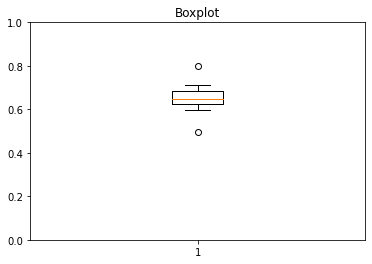

median value: 0.6490908040200223


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

data = []
for g in gene_name:
    pearson_r, _ = pearsonr(original_count_df[g], data_ours[g])
    print(g, pearson_r)
    data.append(pearson_r)
    
plt.boxplot(data)
plt.ylim(0, 1)
plt.title('Boxplot')

plt.show()
print('median value:', np.median(data))

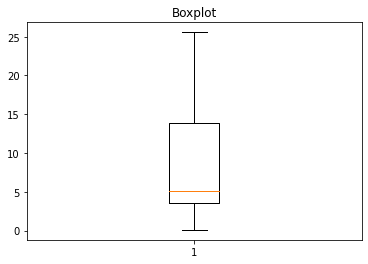

5.1433867161080125


In [11]:
from sklearn.metrics import mean_squared_error as mse

data_mse = []
for idx in range(original_count.shape[1]):
    mse_value = mse(original_count[:, idx], hr_count[:, idx])
    data_mse.append(mse_value)
    
# 绘制箱线图
plt.boxplot(data_mse)
# 添加标题
plt.title('Boxplot')

# 显示图形
plt.show()
print(np.median(data_mse))

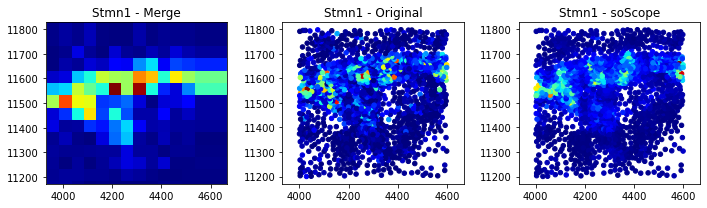

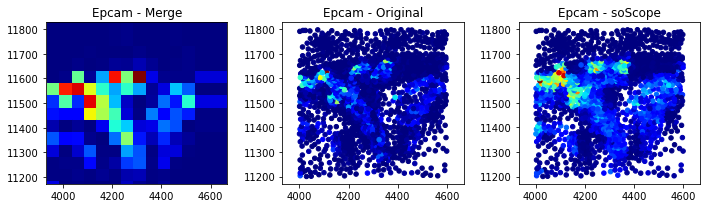

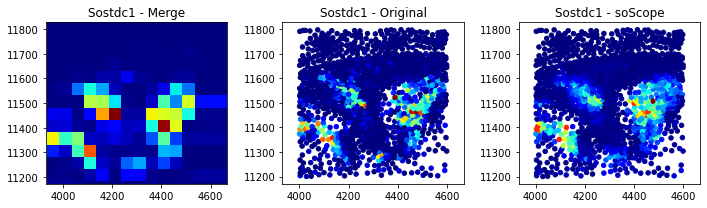

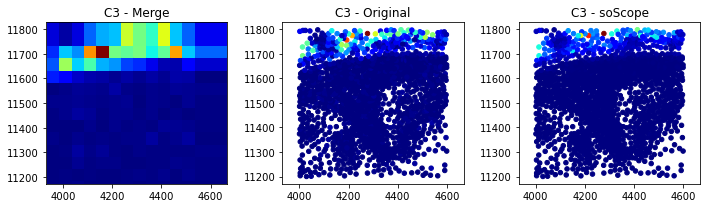

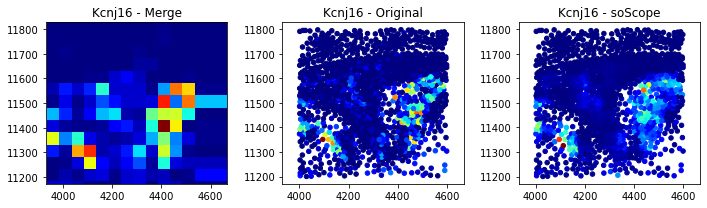

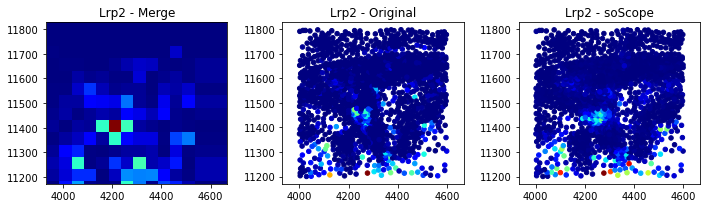

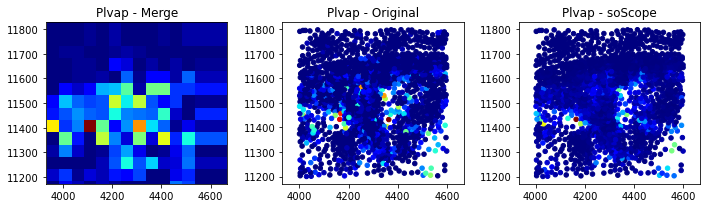

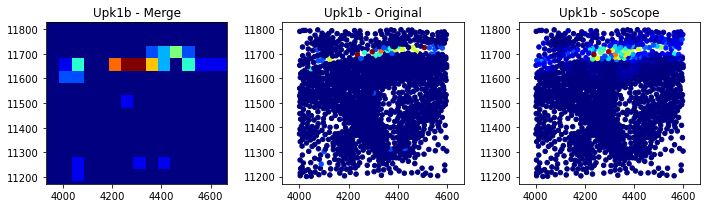

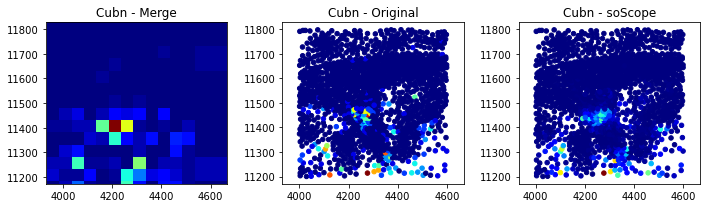

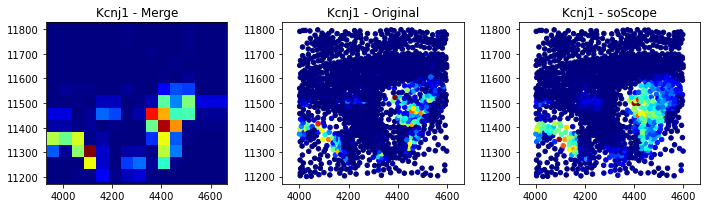

In [15]:
# Simulated resolution enhancement visualization. 
# Visualized data: 10 selceted genes (5 abundant genes + 5 highly variable genes).
# arrangment in subplot: merged data (left) at low resolution, ground truth data (middle), 
# and scScope (right) predicted data at enhanced resolution


import matplotlib.pyplot as plt
import numpy as np
cmp = 'jet'
for g in original_count_df.keys():
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs = axs.ravel()

    c_l = lr_count_df[g]
    axs[0].scatter(np.array(col), np.array(row), s=1000, marker='s', c=c_l, cmap=cmp)
    axs[0].set_title(f'{g} - Merge')

    coriginal = original_count_df[g]
    axs[1].scatter(en_col, en_row, s=20, marker='o', c=coriginal, cmap=cmp, vmin=0)
    axs[1].set_title(f'{g} - Original')

    c = data_ours[g]
    axs[2].scatter(np.array(en_col), np.array(en_row), s=20, marker='o', c=c, cmap=cmp)
    axs[2].set_title(f'{g} - soScope')

    for ax in axs:
        ax.axis('equal')

    plt.tight_layout()
    plt.show()
